# GR & DUSP1 Gating and Normalization Notebook

**Description:**  
This notebook builds on the outputs of the **GR_DUSP1_Confirmation** analysis. It loads pre-inspected single-cell CSV exports, applies cytoplasm area estimation, gating, and SSIT normalization, and writes out two final “SSITFinal” tables for downstream analysis.

---

## Required Inputs

- **DUSP1 reference CSVs** (all prefixed with your experiment/date):
  - `*_SSITcellresults.csv`  
  - `*_FinalSpots.csv`  
  - `*_FinalClusters.csv`  
  - `*_FinalCellProps.csv`  

- **GR experiment CSV** (post-illumination correction & replica scaling):
  - `GR_IC_Gated_Normed_SSITFinal_<date>.csv`

---

## Workflow

1. **Load data**  
   - Import the four DUSP1 CSVs into a single DataFrame (`ssit_all`).  
   - Import the GR CSV into `gr_data`.

2. **Cytoplasm area estimation**  
   - Fit a 2nd-degree polynomial mapping `nuc_area → cyto_area` on gated DUSP1 cells.  
   - Apply that polynomial to predict `CalcCytoArea` in the GR dataset.

3. **Cell gating**  
   - Gate both datasets to the 25th–75th percentile of nuclear area to exclude debris and doublets.  
   - Drop GR timepoints that lack full replicas.

4. **Compute area ratio & normalization**  
   - Calculate the global (nuc:cyto) area ratio from gated DUSP1 cells.  
   - Bin GR cytoplasmic intensities into `normGRcyt`; derive nuclear bins (`normGRnuc`) via the area ratio.

5. **Finalize “SSITFinal” tables**  
   - Subset each gated DataFrame to the columns required for SSIT.  
   - Export clean, ready-to-use CSVs:  
     - `DUSP1_Gated_SSITFinal_<date>.csv`  
     - `GR_IC_Gated_Normed_SSITFinal_<date>.csv`

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime
import glob

# Today's date
today = datetime.date.today()
# Format date as 'Jun03' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1 import DUSP1DisplayManager, PostProcessingPlotter, ExperimentPlotter

/Users/ericron/Desktop/AngelFISH


In [2]:
# Base directory containing your CSV files
base_dir = "/Volumes/share/Users/Eric/GR_DUSP1_AllData/DUSP1_FinalAnalysis_062425"
save_dir = "/Volumes/share/Users/Eric/GR_DUSP1_AllData/GR_DUSP1_FinalAnalysis_090625"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
# Helper to load and concat by pattern
def load_and_concat(pattern):
    paths = glob.glob(os.path.join(base_dir, pattern))
    dfs = []
    for path in paths:
        df = pd.read_csv(path)
        # normalize columns to lowercase
        df.columns = [c.lower() for c in df.columns]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [4]:
# Load each DUSP1 dataset
ssit_all      = load_and_concat("*_SSITcellresults.csv")
spots_all     = load_and_concat("*_FinalSpots.csv")
clusters_all  = load_and_concat("*_FinalClusters.csv")
cellprops_all = load_and_concat("*_FinalCellProps.csv")

# Extract replica letter from strings like "D_slide1", "E_day2", etc.
for df in [ssit_all, spots_all, clusters_all, cellprops_all]:
    df['replica'] = df['replica'].str.extract(r'^([D-N])_')

# Optional: warn if any entries didn’t match
for name, df in zip(
    ['SSIT', 'Spots', 'Clusters', 'CellProps'],
    [ssit_all, spots_all, clusters_all, cellprops_all]
):
    n_missing = df['replica'].isna().sum()
    if n_missing > 0:
        print(f"Warning: {n_missing} entries in {name} did not match replica pattern.")

# Quick check on length of each dataset
print(f"SSIT cells: {len(ssit_all)}")
print(f"Spots:      {len(spots_all)}")
print(f"Clusters:   {len(clusters_all)}")
print(f"Cell props: {len(cellprops_all)}")

SSIT cells: 41872
Spots:      7286078
Clusters:   42162
Cell props: 41872


In [5]:
# Load in the GR data
gr_data = pd.read_csv('/Volumes/share/Users/Eric/GR_DUSP1_AllData/GR_FinalAnalysis_073025/GR_ALL_IC_filtered_scaled_080525.csv')

Fitted polynomial coefficients (a, b, c): [ 2.56481216e-04 -2.41804666e+00  1.73428832e+04]


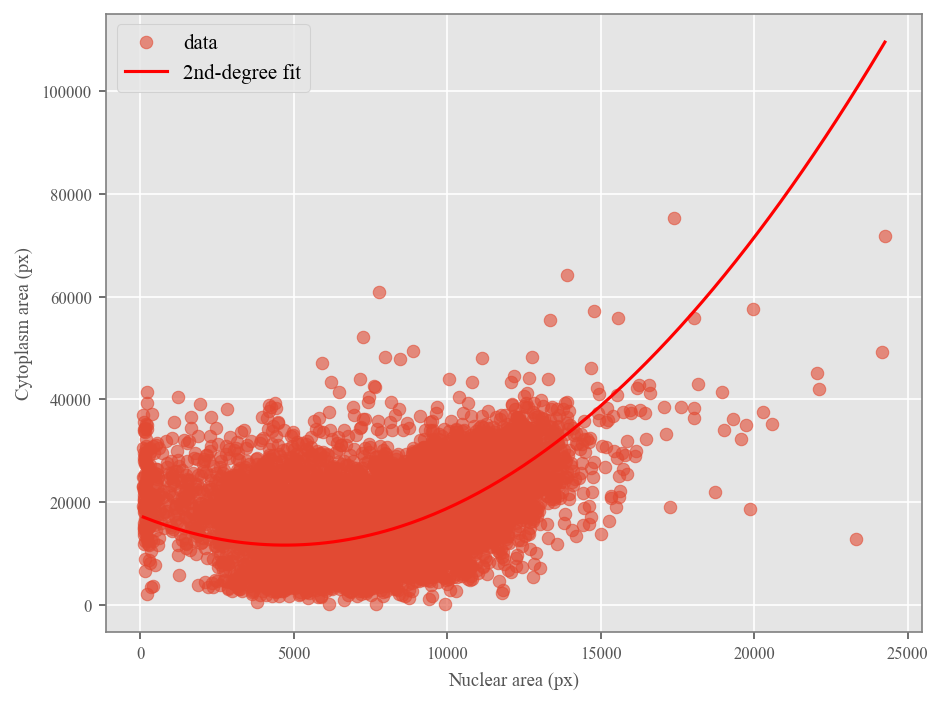

Predict the cyto area of GR from dusp1
+++ Gating Nuc Area +++
DUSP1_ALL original: 41871 rows -> gated: 20946 rows
GR_ALL original:    15957 rows -> gated: 7983 rows
Estimated (Nuc : Cyto) area ratio = 0.5513971764562083
    nucGRint_scaled  cytoGRint_scaled  normGRnuc  normGRcyt
1       4423.350914       2689.614602         14         16
5       3657.799647       2451.369510         10         14
11      4595.648192       2894.419094         15         18
12      3911.455660       2553.856616         11         15
13      4855.391833       3245.142530         16         21


In [6]:
# 2) FIT POLYNOMIAL TO (NUC, CYTO) FROM DUSP1_ALL
# =========================
# We'll use only the rows that have valid nuc_area_px and cyto_area_px.


# 2a) Drop any rows with missing areas
ssit_clean = ssit_all.dropna(subset=['nuc_area','cyto_area'])

# 2b) Check you have enough points
if len(ssit_clean) < 3:
    raise ValueError(f"Not enough points for a 2nd‐degree fit ({len(ssit_clean)} rows).")

# 2c) Fit 2nd‐degree polynomial
x_nuc = ssit_clean['nuc_area'].astype(float).values
y_cyto = ssit_clean['cyto_area'].astype(float).values
poly_coeffs = np.polyfit(x_nuc, y_cyto, deg=2)
print("Fitted polynomial coefficients (a, b, c):", poly_coeffs)

# 2d) Plot fit
plt.scatter(x_nuc, y_cyto, label='data', alpha=0.6)
x_fit = np.linspace(x_nuc.min(), x_nuc.max(), 200)
y_fit = np.polyval(poly_coeffs, x_fit)
plt.plot(x_fit, y_fit, color='red', label='2nd-degree fit')
plt.xlabel('Nuclear area (px)')
plt.ylabel('Cytoplasm area (px)')
plt.legend()
plt.tight_layout()
plt.show()


# 3) ESTIMATE CYTO AREA IN GR_ALL
# =========================
# We'll store the computed cytoplasm area in a new column: 'CalcCytoArea'
# Evaluate the polynomial at GR_ALL['nuc_area'].
print('Predict the cyto area of GR from dusp1')
gr_data['CalcCytoArea'] = np.polyval(poly_coeffs, gr_data['nuc_area'])

# 4) GATE BOTH DATAFRAMES ON [25%, 75%] NUCLEAR AREA
# =========================
num_cells = ssit_clean.shape[0]
def gate_on_nuc_area(df, nuc_col):
    """Return a copy of df gated to [25th, 75th percentile] of nuc_col."""
    lower = df[nuc_col].quantile(0.25)
    upper = df[nuc_col].quantile(0.75)
    return df[(df[nuc_col] >= lower) & (df[nuc_col] <= upper)].copy()

# Gate DUSP1_ALL on nuc_area
print('+++ Gating Nuc Area +++')
df_dusp_gated = gate_on_nuc_area(ssit_clean, 'nuc_area') 

# Gate GR_ALL on nuc_area
df_gr_gated = gate_on_nuc_area(gr_data, 'nuc_area')

print(f"DUSP1_ALL original: {len(ssit_clean)} rows -> gated: {len(df_dusp_gated)} rows")
print(f"GR_ALL original:    {len(gr_data)} rows -> gated: {len(df_gr_gated)} rows")

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.histplot(ssit_clean['nuc_area'], bins=30, color='skyblue', edgecolor='black')
# plt.title("Nuclear Area (Before Gating)")
# plt.subplot(1, 2, 2)
# sns.histplot(df_dusp_gated['nuc_area'], bins=30, color='orange', edgecolor='black')
# plt.title("Nuclear Area (After Gating)")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.histplot(gr_data['nuc_area'], bins=30, color='skyblue', edgecolor='black')
# plt.title("Nuclear Area (Before Gating) IC")
# plt.subplot(1, 2, 2)
# sns.histplot(df_gr_gated['nuc_area'], bins=30, color='orange', edgecolor='black')
# plt.title("Nuclear Area (After Gating) IC ")
# plt.tight_layout()
# plt.show()


# # (Optional) Save a copy of the gated GR data
# df_gr_gated.to_csv("GR_ALL_Gated_On_Nuc.csv", index=False)

# 4) ESTIMATE CYTO AREA IN GR_ALL
# =========================

nuc_mean = df_dusp_gated['nuc_area'].mean()
cyto_mean = df_dusp_gated['cyto_area'].mean()
ratio = nuc_mean / cyto_mean
print("Estimated (Nuc : Cyto) area ratio =", ratio)

# Remove timepoints 20, 40, 60, 90, 150 without replicas
timepoints_to_remove = [20, 40, 60, 90, 150]
df_gr_gated = df_gr_gated[~df_gr_gated['time'].isin(timepoints_to_remove)]

# # (Optional) Randomly assign Dex=0 rows to 1, 10, 100 nM
# # Find rows where Dex_Conc == 0
# mask_zero = (df_gr_gated['Dex_Conc'] == 0)
# n_zero = mask_zero.sum()
# if n_zero > 0:
#     # Generate random indices in [0, 2] for each zero row
#     rand_indices = np.random.randint(0, 3, size=n_zero)
#     dex_values = [1, 10, 100]
#     df_gr_gated.loc[mask_zero, 'Dex_Conc'] = [dex_values[i] for i in rand_indices]


# 5) COMPUTE "NORMALIZED" GR FOR NUC & CYTO IN GR_ALL
# =========================
#  Define bins & threshold:
binsCyt = 30
threshold = 0.01

#  Sort cytoplasmic intensities:
sortGRcyt = df_gr_gated['cytoGRint_scaled'].sort_values().values

#  Identify the indices for the 1% and 99% cutoffs
low_idx  = int(np.ceil(threshold * len(sortGRcyt))) - 1
high_idx = int(np.ceil((1 - threshold) * len(sortGRcyt))) - 1


#  Gather the min/max thresholds
minThreshold = sortGRcyt[low_idx]
maxCytGR     = sortGRcyt[high_idx]


def apply_cyt_norm(values):
    # Scale to [0,1] based on [minThreshold, maxCytGR], then clip
    scaled = (values - minThreshold) / (maxCytGR - minThreshold)
    clipped = np.clip(scaled, 0, 1)
    return np.round(clipped * binsCyt).astype(int)

# Compute normGRcyt:
df_gr_gated['normGRcyt'] = apply_cyt_norm(df_gr_gated['cytoGRint_scaled'])

# Brian's Matlab logic for the nuclear intensity:
#   'nucGRLevel = ratio * Nuc_GR_avg_int', then scale by the same [minThreshold, maxCytGR].
df_gr_gated['nucGR_Level'] = ratio * df_gr_gated['nucGRint_scaled']
df_gr_gated['normGRnuc']   = apply_cyt_norm(df_gr_gated['nucGR_Level'])

# Remove intermediate column:
df_gr_gated.drop(columns=['nucGR_Level'], inplace=True)

# Debug: check a few rows
print(df_gr_gated[['nucGRint_scaled','cytoGRint_scaled','normGRnuc','normGRcyt']].head())

# Save the gated GR data with normalized GR columns
df_gr_gated.to_csv(os.path.join(save_dir, f"GR_IC_Gated_Normed_SSITFinal_{date_str}.csv"), index=False)

# Save the gated DUSP1_ALL data
df_dusp_gated.to_csv(os.path.join(save_dir, f"DUSP1_Gated_SSITFinal_{date_str}.csv"), index=False)

In [ ]:
# Load the gated data (if already saved)

GR_SSIT = pd.read_csv(f'/Volumes/share/Users/Eric/GR_DUSP1_AllData/GR_DUSP1_FinalAnalysis_090625/GR_IC_Gated_Normed_SSITFinal_Aug06.csv')
DUSP1_SSIT = pd.read_csv(f'/Volumes/share/Users/Eric/GR_DUSP1_AllData/GR_DUSP1_FinalAnalysis_090625/DUSP1_Gated_SSITFinal_Aug06.csv')

In [ ]:
plotter = ExperimentPlotter(DUSP1_SSIT)

# 1) 100 nM Time Sweep:
plotter.plot_experiment(
    replicas=['D','E','F','M','N'],
    times=[10,20,30,40,50,60,75,90,120,150,180],
    concs=[100],
    save_dir=save_dir
)

# 2) 75 min Conc Sweep:
plotter.plot_experiment(
    replicas=['G','H','I'],
    times=[75],
    concs=[0.001,0.01,0.1,1,10,100,1000,10000],
    save_dir=save_dir
)

# 3) Both‐varying: 0.3,1,10 nM across multiple times:
plotter.plot_experiment(
    replicas=['J','K','L'],
    times=[30,50,75,90,120,180],
    concs=[0.3,1,10],
    save_dir=save_dir
)